In [25]:
from transformers import CLIPTokenizer,CLIPTextModel
import re
import numpy as np
import torch
import torch.nn as nn
import argparse
import matplotlib.pyplot as plt



from PIL import Image, ImageFont, ImageDraw, ImageOps


In [26]:
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
class TextConditioner(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer=CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14') #processes the tokenized text to extract embeddings
        self.tokenizer=CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14') #convert raw text into tokens

        
        self.transformer.eval()
        for param in self.transformer.parameters():
            param.requires_grad=False


    def forward(self, prompt_list):
        print("The prompt list is: ",prompt_list)
        batch_encoding = self.tokenizer(prompt_list, truncation=True, max_length=77, return_length=True, return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        # print("output from tokenizer:",batch_encoding)
        
        # words = self.tokenizer.convert_ids_to_tokens(batch_encoding['input_ids'].view(-1).tolist()) 
        # print(words)

        text_embedding = self.transformer(batch_encoding["input_ids"].cuda())
        print(text_embedding.last_hidden_state.shape)
        return text_embedding.last_hidden_state.cuda(), batch_encoding["attention_mask"].cuda() # 1, 77, 768 and  1, 768


In [28]:
class LayoutTransformer(nn.Module):
    def __init__(self,layer_number=2):
        super().__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer = torch.nn.TransformerEncoder(
            self.encoder_layer, num_layers=layer_number 
        )
        
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        self.decoder_transformer = torch.nn.TransformerDecoder(
            self.decoder_layer, num_layers=layer_number 
        )

        self.mask_embedding = nn.Embedding(2,512)
        self.length_embedding = nn.Embedding(256,512)
        self.width_embedding = nn.Embedding(256,512)
        self.position_embedding = nn.Embedding(256,512)
        self.state_embedding = nn.Embedding(256,512)
        self.match_embedding = nn.Embedding(256,512)
        
        self.x_embedding = nn.Embedding(512,512)
        self.y_embedding = nn.Embedding(512,512)
        self.w_embedding = nn.Embedding(512,512)
        self.h_embedding = nn.Embedding(512,512)
        
        self.encoder_target_embedding = nn.Embedding(256,512)

        self.input_layer = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
        )

        self.output_layer = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
        )
        
    def forward(self,x,length,width,mask,state,match,target,right_shifted_boxes,train=False,encoder_embedding=None):
        """
        parameters:
            - x: 
            - target: store state and box coordinates of each token 

        """
        # detect whether the encoder_embedding is cached
        if encoder_embedding is None:
            # augmentation
            if train:
                width=width+torch.randint(-3,3,(width.shape[0],width.shape[1])).cuda()


            x=self.input_layer(x)
            
            width_embedding=self.width_embedding(torch.clamp(width,0,255).long()) #(1,77,512)
            encoder_target_embedding=self.encoder_target_embedding(target[:,:,0].long()) #(1,77,512)
            pe_embedding=self.position_embedding(torch.arange(77).cuda().unsqueeze(0)) #(1,77,512)
            total_embedding=x+width_embedding+encoder_target_embedding+pe_embedding
            total_embedding=total_embedding.permute(1,0,2) #(77,1,512)
            encoder_embedding=self.transformer(total_embedding) #(77,1,512)


        right_shifted_boxes_resize=(right_shifted_boxes*512).long() #(1,8,4)
        right_shifted_boxes_resize=torch.clamp(right_shifted_boxes_resize,0,512) #(1,8,4)



        # decoder_pe
        pe_decoder=torch.arange(8).cuda()
        pe_embedding_decoder=self.position_embedding(pe_decoder).unsqueeze(0) #(1,8,512)
        decoder_input=pe_embedding_decoder+self.x_embedding(right_shifted_boxes_resize[:,:,0])+self.y_embedding(right_shifted_boxes_resize[:,:,1])+self.w_embedding(right_shifted_boxes_resize[:,:,2])+self.h_embedding(right_shifted_boxes_resize[:,:,3]) #(1,8,512)

        decoder_input=decoder_input.permute(1,0,2) #(8,1,512)

        # generate triangular mask
        mask=nn.Transformer.generate_square_subsequent_mask(8) #(8,8)
        mask=mask.cuda() #(8,8)
        print(decoder_input.shape)
        print(encoder_embedding.shape)
        print("Mask: ",mask)
        decoder_result = self.decoder_transformer(decoder_input, encoder_embedding, tgt_mask=mask) # (8, 1, 512)
        print(decoder_result.shape)
        decoder_result=decoder_result.permute(1,0,2) #(1,8,512)

        box_prediction=self.output_layer(decoder_result)
        
        return box_prediction,encoder_embedding                

In [29]:
text_encoder = TextConditioner().cuda().eval()
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

In [30]:
import string 

alphabet=string.digits+string.ascii_lowercase+string.ascii_uppercase+string.punctuation+' '
alphabet_dic={}
for index,c in enumerate(alphabet):
    alphabet_dic[c]=index-1 #the index starts with 0 for for non-character


def adjust_font_size(font_path,width,height,draw,text):

    size_start=height
    while True:
        font=ImageFont.truetype(font_path,size_start)
        text_width=draw.textlength(text,font=font)
        if text_width>=width:
            size_start=size_start-1
        else:
            return size_start

def get_width(font_path, text):
    """
    This function calculates the width of the text.
    
    Args:
        font_path (str): user prompt.
        text (str): user prompt.
    """
    font = ImageFont.truetype(font_path, 24)
    # bbox = font.getbbox(text)
    # width=bbox[2]-bbox[0]
    # height=bbox[3]-bbox[1]

    width=font.getlength(text)

    return width

def get_key_words(text: str):
    """
    This function detect keywords (enclosed by quotes) from user prompts. The keywords are used to guide the layout generation.
    
    Args:
        text (str): user prompt.
    """

    words = []
    text = text
    matches = re.findall(r"'(.*?)'", text) # find the keywords enclosed by ''
    
    if matches:
        for match in matches:
            # words.append(match.split())
            words.append(match)
            
    if len(words) >= 8:
        return []
    
    # print(words)
    
    return words


def adjust_overlap_box(box_output, current_index):
    """
    This function adjust the overlapping boxes.
    
    Args:
        box_output (List): List of predicted boxes.
        current_index (int): the index of current box.
    """
    
    if current_index == 0:
        return box_output
    else:
        # judge whether it contains overlap with the last output
        last_box = box_output[0, current_index-1, :]
        xmin_last, ymin_last, xmax_last, ymax_last = last_box
        
        current_box = box_output[0, current_index, :]
        xmin, ymin, xmax, ymax = current_box
        
        if xmin_last <= xmin <= xmax_last and ymin_last <= ymin <= ymax_last:
            print('adjust overlapping')
            distance_x = xmax_last - xmin
            distance_y = ymax_last - ymin
            if distance_x <= distance_y:
                # avoid overlap
                new_x_min = xmax_last + 0.025
                new_x_max = xmax - xmin + xmax_last + 0.025
                box_output[0,current_index,0] = new_x_min
                box_output[0,current_index,2] = new_x_max
            else:
                new_y_min = ymax_last + 0.025
                new_y_max = ymax - ymin + ymax_last + 0.025
                box_output[0,current_index,1] = new_y_min
                box_output[0,current_index,3] = new_y_max  
                
        elif xmin_last <= xmin <= xmax_last and ymin_last <= ymax <= ymax_last:
            print('adjust overlapping')
            new_x_min = xmax_last + 0.05
            new_x_max = xmax - xmin + xmax_last + 0.05
            box_output[0,current_index,0] = new_x_min
            box_output[0,current_index,2] = new_x_max
                    
        return box_output
    
def shrink_box(box,scale_factor=0.9):

    x1,y1,x2,y2=box
    x1_new=x1+(x2-x1)*(1-scale_factor)/2
    y1_new=y1+(y2-y1)*(1-scale_factor)/2
    x2_new=x2-(x2-x1)*(1-scale_factor)/2
    y2_new=y2-(y2-y1)*(1-scale_factor)/2

    return (x1_new,y1_new,x2_new,y2_new)

        

In [31]:
def process_caption(font_path,caption,keywords):
    # remove punctuations. please remove this statement if you want to paint punctuations
    caption = re.sub(u"([^\u0041-\u005a\u0061-\u007a\u0030-\u0039])", " ", caption) 

    caption_words=tokenizer([caption],truncation=True, max_length=77, return_length=True, return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
    print(caption_words)

    caption_words_ids = caption_words['input_ids'] # (1, 77)  (tokens)
    # print(caption_words_ids)
    length = caption_words['length'] # (1, )
    print(length) #sent_len+2 for sos and eos

    # convert id back to words
    words = tokenizer.convert_ids_to_tokens(caption_words_ids.view(-1).tolist()) 
    # print(words)
    words = [i.replace('</w>', '') for i in words]
    # print(words)
    words_valid = words[:int(length)]  #since padding of max_length so after eot tag still eot till 77 will be added
    print(words_valid) 



    # split the caption into words and convert them to lower case
    caption_split = caption.split() 
    caption_split=[i.lower() for i in caption_split]
    print(caption_split)

    start_dic={}  # get the start index of each word
    state_list=[] # 0: start, 1: middle, 2: special token
    word_match_list=[]  # the index of the word in the caption
    current_caption_index=0
    current_match=''

    for i in range(length):
        
        # use first and last token as special tokens
        if i==0 or i==length-1:
            state_list.append(2) 
            word_match_list.append(127)
            continue
            
        if current_match=='':
            state_list.append(0)
            start_dic[current_caption_index]=i

        else:
            state_list.append(1)

        current_match+=words_valid[i]
        word_match_list.append(current_caption_index)
        if current_match==caption_split[current_caption_index]:
            current_match=''
            current_caption_index+=1

        
    
    print(state_list) 
    print(word_match_list)

    while len(state_list)<77:
        state_list.append(127)
    
    while len(word_match_list)<77:
        word_match_list.append(127)

    # print(state_list) 
    # print(word_match_list)


    length_list=[]
    width_list=[]

    for i in range(len(word_match_list)):
        if word_match_list[i]==127:
            length_list.append(0)
            width_list.append(0)
        else:
            length_list.append(len(caption.split()[word_match_list[i]]))  #storing the lenght of the word
            width_list.append(get_width(font_path,caption.split()[word_match_list[i]])) #for 

    
    length_list = torch.Tensor(length_list).long() # (77, ) with torch.int64
    width_list = torch.Tensor(width_list).long() # (77, )


    boxes=[]
    duplicate_dict={} #some words may appear more than once
    
    # store the box coordinates and state of each token
    info_array = np.zeros((77,5)) # (77, 5)
    

    for keyword in keywords:
        keyword = keyword.lower()
        if keyword in caption_split:
            if keyword not in duplicate_dict:
                duplicate_dict[keyword] = caption_split.index(keyword) #get the index of the keyword in the sentence
                index = caption_split.index(keyword)
            else:
                if duplicate_dict[keyword]+1 < len(caption_split) and keyword in caption_split[duplicate_dict[keyword]+1:]:
                    index = duplicate_dict[keyword] + caption_split[duplicate_dict[keyword]+1:].index(keyword)
                    duplicate_dict[keyword] = index
                else:
                    continue
                
            index = caption_split.index(keyword) 
            index = start_dic[index] 
            info_array[index][0] = 1 #index denote the position of the keyword in the words list

            box = [0,0,0,0] 
            boxes.append(list(box))
            info_array[index][1:] = box
    
    boxes_length=len(boxes)
    if boxes_length>8:  #if keywords are more than 8
        boxes=boxes[:8]
    while len(boxes)<8:
        boxes.append([0,0,0,0])


    return caption,length_list,width_list,torch.from_numpy(info_array),words,torch.Tensor(state_list).long(),torch.Tensor(word_match_list).long(),torch.Tensor(boxes),boxes_length
    

        






In [32]:
model=LayoutTransformer().cuda().eval()
model.load_state_dict(torch.load('textdiffuser-ckpt/layout_transformer.pth'))


/home/adi_techbuddy/anaconda3/envs/torchenv/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [33]:
def get_layout_from_prompt(caption):

    font_path='/home/adi_techbuddy/Desktop/python/repos/brush-your-text/controlnet_util/Textgen/English/Roboto/static/Roboto-Regular.ttf'
    # caption="I love 'nlp' and 'ai'"

    text_embedding,mask=text_encoder(caption)
    print(text_embedding.shape)


    keywords=get_key_words(caption)
    print("The following words to be displayed in image were detected",keywords)

    caption,length_list,width_list,target,words,state_list,word_match_list,boxes,boxes_length=process_caption(font_path,caption,keywords)

    
    print("target_shape: ",target.shape)
    target=target.cuda().unsqueeze(0)
    print("target_shape_after_squezzing: ",target.shape)

    print(width_list.shape)
    width_list=width_list.cuda().unsqueeze(0) #(1,77)
    length_list=length_list.cuda().unsqueeze(0)
    state_list=state_list.cuda().unsqueeze(0)
    word_match_list=word_match_list.cuda().unsqueeze(0)


    padding=torch.zeros(1,1,4).cuda()

    print(boxes.shape)
    boxes=boxes.unsqueeze(0).cuda() #(1,8,4) it is storing keywords boxes with padding till 8
    right_shifted_boxes=torch.cat([padding,boxes[:,0:-1,:]],1)

    print(right_shifted_boxes.shape)

    # inference 
    return_boxes=[]
    with torch.no_grad():
        for box_index in range(boxes_length):

            if box_index==0:
                encoder_embedding=None
            
            output, encoder_embedding = model(text_embedding, length_list, width_list, mask, state_list, word_match_list, target, right_shifted_boxes, train=False, encoder_embedding=encoder_embedding)             
            output=torch.clamp(output,min=0,max=1)
            # add overlap detection 
            output=adjust_overlap_box(output,box_index)


            right_shifted_boxes[:,box_index+1,:]=output[:,box_index ,:]
            xmin,ymin,xmax,ymax=output[0,box_index,:].tolist()
            return_boxes.append([xmin,ymin,xmax,ymax])


    
     # print the location of keywords
    print(f'index\tkeyword\tx_min\ty_min\tx_max\ty_max')
    for index, keyword in enumerate(keywords):
        x_min = int(return_boxes[index][0] * 512)
        y_min = int(return_boxes[index][1] * 512)
        x_max = int(return_boxes[index][2] * 512)
        y_max = int(return_boxes[index][3] * 512)
        print(f'{index}\t{keyword}\t{x_min}\t{y_min}\t{x_max}\t{y_max}')


    
    #paint the layout
    render_image=Image.new('RGB',(512,512),(255,255,255))
    draw= ImageDraw.Draw(render_image)
    segmentation_mask = Image.new("L", (512,512), 0)
    segmentation_mask_draw = ImageDraw.Draw(segmentation_mask)


    for index,box in enumerate(return_boxes):
        box = [int(i*512) for i in box]
        xmin, ymin, xmax, ymax = box
        
        width = xmax - xmin
        height = ymax - ymin
        text = keywords[index]

        font_size = adjust_font_size(font_path, width, height, draw, text)
        font = ImageFont.truetype(font_path, font_size)

        # draw.rectangle([xmin, ymin, xmax,ymax], outline=(255,0,0))
        draw.text((xmin, ymin), text, font=font, fill=(0, 0, 0))
            
        boxes = []
        for i, char in enumerate(text):
            
            # paint character-level segmentation masks
            # https://github.com/python-pillow/Pillow/issues/3921
            
            # bottom_1=font.getsize(text[i])[1] ##deprecetaed
            # right,bottom_2=font.getsize(text[:i+1])

            bottom_1 = font.getbbox(text[i])[3]
            l,t,r, bottom_2 = font.getbbox(text[:i+1])
            right=r-l
            bottom = bottom_1 if bottom_1 < bottom_2 else bottom_2
            width, height = font.getmask(char).size
            right += xmin
            bottom += ymin
            top = bottom - height
            left = right - width
            
            char_box = (left, top, right, bottom)
            boxes.append(char_box)
            
            char_index = alphabet_dic[char]
            segmentation_mask_draw.rectangle(shrink_box(char_box, scale_factor = 0.9), fill=char_index)

    return render_image,segmentation_mask



            
            




In [35]:
caption="Hey there this is 'aditya'"
img,segmentation_mask=get_layout_from_prompt(caption)

The prompt list is:  Hey there this is 'aditya'
torch.Size([1, 77, 768])
torch.Size([1, 77, 768])
The following words to be displayed in image were detected ['aditya']
{'input_ids': tensor([[49406,  2189,   997,   589,   533, 37186, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'length': tensor([7]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 

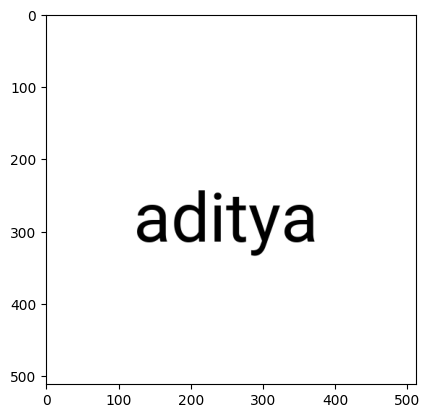

In [36]:
plt.imshow(img)

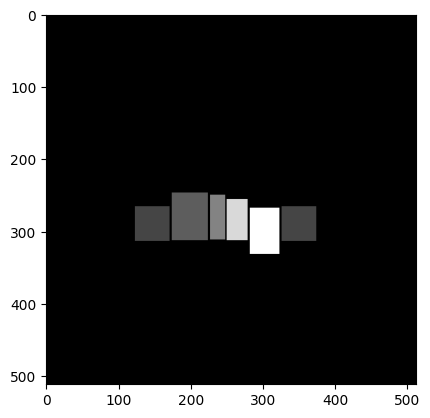

In [37]:
plt.imshow(segmentation_mask,cmap='gray')